Model Importing and Testing Model

In [18]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3

In [19]:

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "plantvillage",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

def partition_dataset(dataset, train_size=0.8, val_size=0.1, test_size=0.1, buffer_size=100):
    dataset = dataset.shuffle(buffer_size)
    n = len(dataset)
    train_n = int(train_size * n)
    val_n = int(val_size * n)
    train_dataset = dataset.take(train_n)
    val_dataset = dataset.skip(train_n).take(val_n)
    test_dataset = dataset.skip(train_n + val_n)
    return train_dataset, val_dataset, test_dataset

train_dataset, val_dataset, test_dataset = partition_dataset(dataset)

train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Found 14529 files belonging to 10 classes.


In [20]:
model_version = 3
model = tf.keras.models.load_model(f"../models/{model_version}")

In [21]:
scores = model.evaluate(test_dataset)
loss = scores[0] * 100
accuracy = scores[1] * 100
print(f"LOSS: {loss:.2f}%")
print(f"ACCURACY: {accuracy:.2f}%")

46/46 [==============================] - 326s 981ms/step - loss: 0.2015 - accuracy: 0.9292
LOSS: 20.15%
ACCURACY: 92.92%


In [22]:
class_names = dataset.class_names
class_names

['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

Generate predictions for the confusion matrix

In [23]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

# Generate predictions for the confusion matrix
y_true = []
y_pred = []

Compute confusion matrix

In [24]:
for images, labels in test_dataset:
    for img, lbl in zip(images, labels):
        predicted_class, _ = predict(model, img.numpy())
        y_true.append(class_names[lbl])
        y_pred.append(predicted_class)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=class_names)

# Replace class names with indices for confusion matrix
class_indices = {name: idx for idx, name in enumerate(class_names)}
y_true_indices = [class_indices[label] for label in y_true]
y_pred_indices = [class_indices[label] for label in y_pred]

cm_indices = confusion_matrix(y_true_indices, y_pred_indices)

1/1 [==============================] - 0s 43ms/step


Plot confusion matrix

C:\Users\Seward\AppData\Local\Temp\ipykernel_8352\1136731794.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the rect parameter to make space for the legend


<Figure size 1200x800 with 0 Axes>

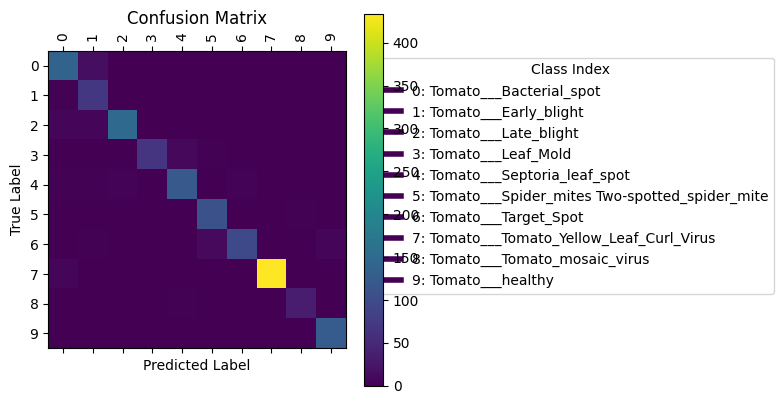

In [26]:
# Plot confusion matrix with numbers and legend
plt.figure(figsize=(12, 8))
cax = plt.matshow(cm_indices, cmap='viridis')
plt.colorbar(cax)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

# Set ticks and labels
plt.xticks(ticks=np.arange(len(class_names)), labels=np.arange(len(class_names)), rotation='vertical')
plt.yticks(ticks=np.arange(len(class_names)), labels=np.arange(len(class_names)))

# Add legend outside the plot
plt.legend(
    handles=[plt.Line2D([0], [0], color=cax.cmap(cax.norm(0)), lw=4) for _ in range(len(class_names))],
    labels=[f'{i}: {name}' for i, name in enumerate(class_names)],
    title="Class Index",
    bbox_to_anchor=(1.05, 1),
    loc='upper left'
)

plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the rect parameter to make space for the legend
plt.show()